In [1]:
import time
import numpy as np
import open3d as o3d
from scipy.spatial.transform import Rotation
import clipperpy
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def read_data_from_txt(txt_file):
    '''
    the txt file should be in the following format in each line:
    label x y z
    get the x y value return a 2 by n numpy array
    '''
    data = np.loadtxt(txt_file, usecols=(0, 1, 2), dtype=np.float64)
    return data.T

def visualize_DA(data_a, data_b, Ain, tf, displacement = 0):
    '''
    data_a: 3 by n numpy array, label, x, y lable range from 0 to -2
    data_b: 3 by m numpy array, label, x, y
    Ain: k by 2 numpy array, mapping point indexed by row in data_a to data_b
    '''
    # draw circles with label 0 in red, label -1 in blue, label -2 in green for data a
    data_a_position = data_a[1:3, :]
    transformed_back_data_b = transform_data(data_b, np.linalg.inv(tf))
    data_b_position = transformed_back_data_b[1:3, :]
    # for each point in data a, draw a line to the corresponding point in data b
    for i in range(Ain.shape[0]):
        a = data_a_position[:, Ain[i, 0]]
        b = data_b_position[:, Ain[i, 1]]
        plt.plot([a[0], b[0]+ displacement] , [a[1], b[1]], 'k-')
    for i in range(data_a_position.shape[1]):
        if data_a[0, i] == 3 or data_a[0, i] == 2:
            plt.plot(data_a_position[0, i], data_a_position[1, i], 'go')
        elif data_a[0, i] == 1:
            plt.plot(data_a_position[0, i], data_a_position[1, i], 'gs')
        elif data_a[0, i] == 0:
            plt.plot(data_a_position[0, i], data_a_position[1, i], 'go')
    for i in range(data_b_position.shape[1]):
        if data_b[0, i] == 3 or data_b[0, i] == 2:
            plt.plot(data_b_position[0, i] + displacement, data_b_position[1, i], 'ro')
        elif data_b[0, i] == 1:
            plt.plot(data_b_position[0, i] + displacement, data_b_position[1, i], 'rs')
        elif data_b[0, i] == 0:
            plt.plot(data_b_position[0, i] + displacement, data_b_position[1, i], 'ro')

    
    plt.show()

def transform_data(data, tf):
    '''
    data: 3 by n numpy array, label, x, y
    tf: 3 by 3 numpy array, 2D transformation matrix
    return data_transformed: 3 by n numpy array, label, x, y
    '''
    data_transformed = np.zeros_like(data)
    data_transformed[0, :] = data[0, :]
    data_xy = data[1:3, :]
    data_xy1 = np.vstack((data_xy, np.ones(data_xy.shape[1]))).T
    data_xy1_transformed = data_xy1 @ tf # n by 3
    data_xy_transformed = data_xy1_transformed[:, 0:2].T # 2 by n
    data_transformed[1:3, :] = data_xy_transformed
    return data_transformed

def visualize_data_a(data):
    '''
    data: 3 by n numpy array, label, x, y
    '''
    data_position = data[1:3, :]
    data_label = data[0, :]
    for i in range(data_position.shape[1]):
        if data_label[i] == 3 or data_label[i] == 2:
            plt.plot(data_position[0, i], data_position[1, i], 'go')
        elif data_label[i] == 1:
            plt.plot(data_position[0, i], data_position[1, i], 'gs')
        elif data_label[i] == 0:
            plt.plot(data_position[0, i], data_position[1, i], 'go')
    plt.show()

def visualize_data_b(data):
    '''
    data: 3 by n numpy array, label, x, y
    '''
    data_position = data[1:3, :]
    data_label = data[0, :]
    for i in range(data_position.shape[1]):
        if data_label[i] == 3 or data_label[i] == 2:
            plt.plot(data_position[0, i], data_position[1, i], 'ro')
        elif data_label[i] == 1:
            plt.plot(data_position[0, i], data_position[1, i], 'rs')
        elif data_label[i] == 0:
            plt.plot(data_position[0, i], data_position[1, i], 'ro')
    plt.show()
    

def generate_DA(size_a, size_b):
    '''
    size_a: number of points in data A
    size_b: number of points in data B
    A: min(size_a, size_b) by 2 numpy array, mapping point indexed by row in data A to data B 
    '''
    DA = np.zeros((size_a*size_b, 2), dtype=np.int32)
    for i in range(size_a):
        for j in range(size_b):
            DA[i*size_b+j, 0] = i
            DA[i*size_b+j, 1] = j
    return DA

def perturb_data(data, Transformation):
    '''
    data: 3 by n numpy array, label, x, y
    Transformation: 3 by 3 numpy array, 2D transformation matrix
    return data_perturbed: 3 by n numpy array, label, x, y
    '''
    data_perturbed = np.zeros_like(data)
    data_perturbed[0, :] = data[0, :]
    data_xy = data[1:3, :]
    data_xy1 = np.vstack((data_xy, np.ones(data_xy.shape[1]))).T
    data_xy1_perturbed = data_xy1 @ Transformation # n by 3
    data_xy_perturbed = data_xy1_perturbed[:, 0:2].T # 2 by n
    data_perturbed[1:3, :] = data_xy_perturbed
    return data_perturbed


In [3]:
data1_file = "/home/jiuzhou/clipper_semantic_object/examples/data/robot0Map_indoor.txt"
data2_file = "/home/jiuzhou/clipper_semantic_object/examples/data/robot2Map_indoor.txt"
D1 = read_data_from_txt(data1_file)
D2 = read_data_from_txt(data2_file)
yaw = 0
dx = 0
dy = 0
perturb_tf = np.array([[np.cos(yaw), -np.sin(yaw), dx], [np.sin(yaw), np.cos(yaw), dy], [0, 0, 1]])
gt_yaw = 0
gt_dx = -0.94
gt_dy = 1.76
gt_tf = np.array([[np.cos(gt_yaw), -np.sin(gt_yaw), gt_dx], [np.sin(gt_yaw), np.cos(gt_yaw), gt_dy], [0, 0, 1]])
D2 = perturb_data(D2, perturb_tf)
print(D1.shape)
print(D2.shape)
D1_position = D1[1:3, :]
D2_position = D2[1:3, :]
A = generate_DA(D1.shape[1], D2.shape[1])
print(A.shape)


(3, 32)
(3, 29)
(928, 2)


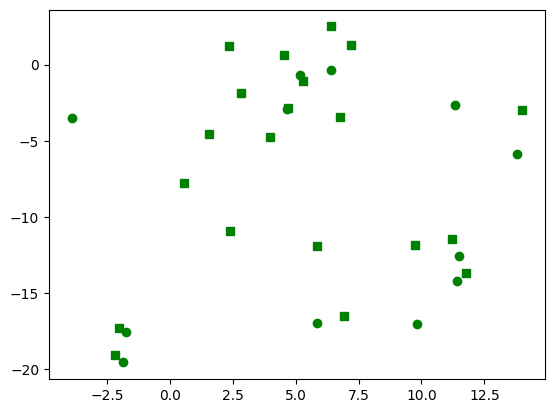

In [4]:
visualize_data_a(D1)

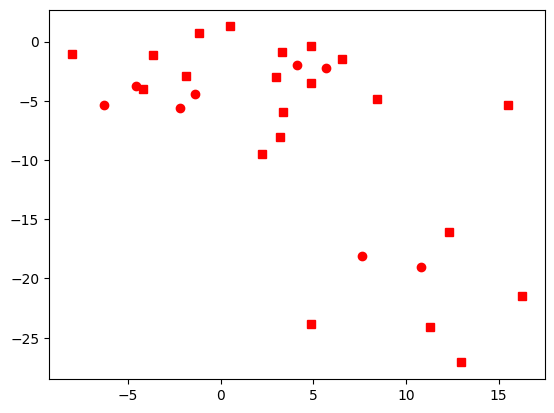

In [5]:
visualize_data_b(D2)

In [6]:
iparams = clipperpy.invariants.EuclideanDistanceParams()
iparams.sigma = 0.1
iparams.epsilon = 0.3
invariant = clipperpy.invariants.EuclideanDistance(iparams)

params = clipperpy.Params()
params.rounding = clipperpy.Rounding.DSD_HEU
clipper = clipperpy.CLIPPER(invariant, params)

In [7]:
t0 = time.perf_counter()
# D1 3 by n
# D2 3 by m
# A: k by 2
clipper.score_pairwise_consistency(D1_position, D2_position, A)
t1 = time.perf_counter()
print(f"Affinity matrix creation took {t1-t0:.3f} seconds")

t0 = time.perf_counter()
clipper.solve()
t1 = time.perf_counter()

# A = clipper.get_initial_associations()
# Ain: k by 2 association
Ain = clipper.get_selected_associations()

Affinity matrix creation took 0.298 seconds


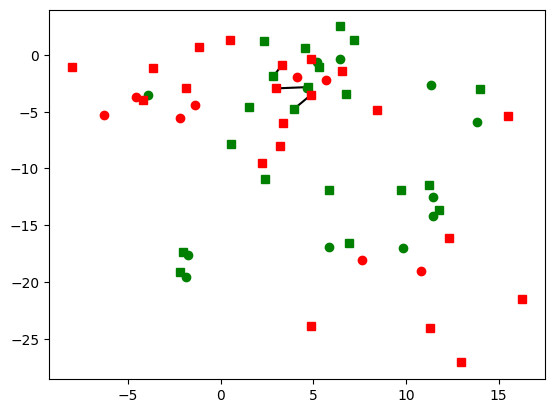

In [8]:
visualize_DA(D1, D2, Ain, gt_tf)